# Test examples of PL IFP computations

    1. Computing interaction fingerprints (IFP) for
        -- a single structure prepared for MD simulations (HSP90; PDB ID 6EI5, dcd format)
        -- a trajectory (for selected frames; dcd format)
        -- PDB structure
    2. Visualizing protein residues that are involved in protein-ligand interactions, including water-bridges
     

### Author: Daria Kokh
    v.1.0
    Copyright (c) 2019
    Released under the GNU Public Licence, v2 or any higher version
    


### Input data required:
    MD trajectory file of a complex
    pdb file of a complex (for example, generated from the first frame)
    pdb and mol2 file of a ligand separately 
    
    
### Packages required:
    numpy
    matplotlib
    MDAnalysis v. 20.1
    pandas
    seaborn
    RDkit
    code is written on Python 3.x and tested on the version 3.7



##  Application example 

    Heat Shock Protein 90 (HSP90)

In [28]:
import glob, os
import sys

import numpy as np

import pandas as pd

from matplotlib import *

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

from Scripts.IFP_generation import *
from Scripts.Trajectories import *
from Scripts.Clustering import *
from Scripts.Complex_structure import *

import nglview as nv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. HSP90 structure (PDB ID 6EI5; prepared for MD simulations)

### 1.1 find chemical properties of the ligand using RDKit 

In [13]:
ligand_pdb = "Data/6EI5//INH.pdb"
ligand_mol2 = "Data/6EI5//moe.mol2"

#---------- read atom names of the ligand 
with open(ligand_pdb, 'r') as ff:
        lines = ff.readlines()
list_labels = []
for line in lines:
    if line.split()[0] == 'ATOM': list_labels.append(line.split()[2]) 
        
#---------- get ligand properties using RDKit----- 
mol = Chem.rdmolfiles.MolFromMol2File(ligand_mol2,removeHs=False)   
ligand_2D =Chem.MolFromSmiles(Chem.MolToSmiles(mol))
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
factory = ChemicalFeatures.BuildFeatureFactory(fdefName)
feats = factory.GetFeaturesForMol(mol)
properties_list = {}
for f in feats:
    prop = f.GetFamily()  #  get property name
    at_indx  = list(f.GetAtomIds())  # get atom index
    if prop not in properties_list.keys():
        properties_list[prop]=[]
    if(len(at_indx) > 0):
        for l in at_indx: properties_list[prop].append(list_labels[l])
    else: properties_list[prop].append(list_labels[at_indx[0]])
print(properties_list)


{'Donor': ['N3', 'N14', 'N30'], 'Acceptor': ['O4', 'N8', 'N10'], 'PosIonizable': ['N30'], 'Aromatic': ['C1', 'C5', 'N8', 'C13', 'N10', 'C6', 'C1', 'C6', 'C9', 'C12', 'C11', 'C7', 'C15', 'C24', 'C25', 'C26', 'C27', 'C28'], 'Hydrophobe': ['C1', 'C7', 'C9', 'C11', 'C12', 'C15', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28'], 'LumpedHydrophobe': ['C1', 'C6', 'C9', 'C12', 'C11', 'C7', 'C15', 'C24', 'C25', 'C26', 'C27', 'C28']}


### 1.2 Generate PL IFPs 

In [14]:
#---------------read energy minimized structure using MDAnalysis-------------
pdb= "Data/6EI5/ref-min.pdb"
property_list = properties_list
ref = mda.Universe(pdb)
#------------- compute IFP and generate IFP table 
df_prop,df_HB,df_WB = IFP(ref,"INH",property_list,WB_analysis=True,RE=False,Lipids= [])
df_prop_complete = table_combine(df_HB,df_WB,df_prop,"INH")

Start HB analysis 14:00:39.260979
Start WB analysis 14:00:39.418779
Start collecting IFPs:  14:00:45.793349
Start building IFP table:  14:00:46.377666
IFP database is ready  14:00:46.378536


### 1.3 Print specific PL IFPs

In [15]:
print("\nProtein RESIDUES thdf_prop_completat interact with the Ligand:\n")
print(df_prop_complete.columns.tolist())
print("\nRESIDUES participating in the Prot.-Wat-Lig H-bond network:")
df_WB


Protein RESIDUES thdf_prop_completat interact with the Ligand:

['time', 'HA_SER36', 'HY_ALA39', 'HA_ASP77', 'WB_ASP77', 'HY_ILE80', 'AR_GLY81', 'HY_GLY81', 'WB_GLY81', 'AR_MET82', 'HY_MET82', 'HY_ASP86', 'HY_LEU91', 'HY_ILE94', 'HY_PHE122', 'HY_VAL134', 'HY_TRP146', 'WB_THR168', 'WAT']

RESIDUES participating in the Prot.-Wat-Lig H-bond network:


,time,sele1_index,sele2_index,sele1_resnm,sele1_resid,sele1_atom,sele2_resnm,sele2_resid,sele2_atom,distance,angle
0,0.0,3295,1248,INH,208,H141,ASP,77,OD1,2.834688,169.151585
1,0.0,3295,1249,INH,208,H141,ASP,77,OD2,2.060964,137.979250
2,0.0,3296,587,INH,208,H142,SER,36,OG,3.419492,112.668037
3,0.0,3311,3264,INH,208,HN30,INH,208,O4,2.360879,140.009442
4,0.0,3295,3379,INH,208,H141,WAT,267,O,3.311105,120.902570
5,0.0,3380,3270,WAT,267,H1,INH,208,N10,1.910151,170.737090
6,0.0,3381,1248,WAT,267,H2,ASP,77,OD1,1.587797,174.207923
7,0.0,3381,1249,WAT,267,H2,ASP,77,OD2,3.335677,140.691594
8,0.0,3379,1293,WAT,267,O,GLY,81,H,2.257524,143.885142
9,0.0,3379,2568,WAT,267,O,THR,168,HG1,1.839259,163.191801


In [16]:
# database with hydrogen bonds
df_HB

,time,donor_index,acceptor_index,donor_resnm,donor_resid,donor_atom,acceptor_resnm,acceptor_resid,acceptor_atom,distance,angle
0,0.0,3295,1248,INH,208,H141,ASP,77,OD1,2.834688,169.151585
1,0.0,3295,1249,INH,208,H141,ASP,77,OD2,2.060964,137.979250
2,0.0,3296,587,INH,208,H142,SER,36,OG,3.419492,112.668037


### This is a complete IFP database. 
    It containes Water bridges between ligand and THR168,ASP77, and GLY81
    Hydrogen bonds between ligand and ASP77  and aromatic contact with GLY81 and  MET82 
    The rest is just hydrophobic interactions

In [17]:
df_prop_complete

,time,HA_SER36,HY_ALA39,HA_ASP77,WB_ASP77,HY_ILE80,AR_GLY81,HY_GLY81,WB_GLY81,AR_MET82,HY_MET82,HY_ASP86,HY_LEU91,HY_ILE94,HY_PHE122,HY_VAL134,HY_TRP146,WB_THR168,WAT
0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4


### 1.4 Visualization of protein residues involved in PL interactions 

In [18]:
#################################################
# visual check : visuzlize all residues participating in protein-ligand water bridges and protein-ligand H-bonds
################################################
view = nv.NGLWidget()
protein = ref.select_atoms('protein or (resname INH WAT)')
w=nv.show_mdanalysis(protein)
w.add_licorice("36  77 81 168 208 264 265 267")
w

NGLWidget()

In [19]:
#################################################
# visual check : let us show all residues participating in protein-ligand contacts 
################################################

view = nv.NGLWidget()
protein = ref.select_atoms('protein or (resname INH WAT)')
w=nv.show_mdanalysis(protein)
#we will select only Aromatic interactions (one can also select only HD , HA, IP, IN, WB, HA)
resi = ""
for ifp in df_prop_complete.columns.tolist():
    if(ifp[:2] == "AR"): resi += str(ifp[6:])+ " "
print(resi)
w.add_licorice(resi)
w

81 82 


NGLWidget()

## 2. Generation of PL IFPs for a single MD trajectory 

### 2.1 Read a trajectory,  compute PL IFPs, and show results

0 RMSD (protein , ligand): [1.8149448168239566, 0.9369309884009814] traj length: 1000
1 RMSD (protein , ligand): [1.8663876765455583, 1.3106771150193275] traj length: 1000
2 RMSD (protein , ligand): [1.824483371709505, 1.3678690520872283] traj length: 1000
3 RMSD (protein , ligand): [1.8584204150682104, 1.193052637550799] traj length: 1000
4 RMSD (protein , ligand): [1.8824416186044164, 1.467007339387443] traj length: 1000
5 RMSD (protein , ligand): [1.8235934222587904, 1.4605073710443868] traj length: 1000
6 RMSD (protein , ligand): [1.8676691534056542, 0.94039910440598] traj length: 1000
7 RMSD (protein , ligand): [1.8555510030471447, 0.8396326466471579] traj length: 1000
8 RMSD (protein , ligand): [1.9695548850571365, 1.2110487607244371] traj length: 1000
9 RMSD (protein , ligand): [1.8171787102327517, 1.5331365685448004] traj length: 1000
10 RMSD (protein , ligand): [1.955475792261257, 0.9194494890246193] traj length: 1000
11 RMSD (protein , ligand): [1.9383495567160693, 0.96845898

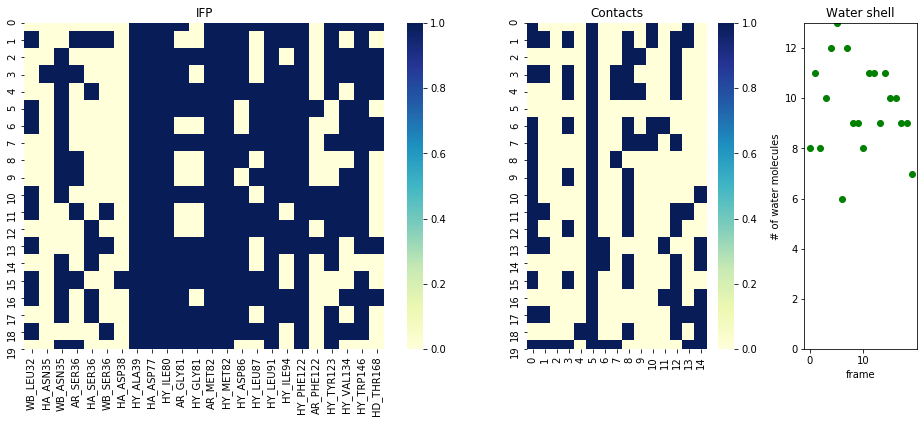

In [20]:
pdb= "Data/6EI5/ref-min.pdb"
ligand_pdb = "Data/6EI5//INH.pdb"
ligand_mol2 = "Data/6EI5//moe.mol2"
trj= "Data/6EI5/amber2namd2.dcd"


ref = mda.Universe(pdb)
#------------ 
Rgr0 = ref.select_atoms("protein").radius_of_gyration()
u = mda.Universe(pdb,trj)
 
u_length = len(u.trajectory)

# load part of the trajectory in the memory
system_reduced = u.select_atoms('protein or (resname INH WAT)')    

step = 50
u_mem = mda.Merge(system_reduced).load_new(AnalysisFromFunction(lambda ag: ag.positions.copy(), system_reduced).run(start=0,stop=-1,step=step).results,format=MemoryReader)

save_pdb = False  # one can save selected snapshots in the pdb format

for i in range(0,len(u_mem.trajectory),1):
    u_mem.trajectory[i]  
    u_mem.dimensions = u.dimensions
    Rgr = pbc(u_mem,Rgr0)# wrap all atoms back to the box, use radius of gyration for checking whether the procedure was successful
    rmsd = superimpose_traj(ref,u_mem,["protein","resname INH"])
    print(i,"RMSD (protein , ligand):",rmsd,"traj length:",u_length)
    if save_pdb == True:
        all_write = u.select_atoms("all")
        all_write.write("/hits/fast/mcm/kokhda/TMP/"+"/namd_protein-"+str(i)+".pdb")

# compute IFP
df_prop,df_HB,df_WB = IFP(u_mem,"INH",property_list,WB_analysis=True,RE=True,Lipids= [])
# build IFP table
df_prop_complete = table_combine(df_HB,df_WB,df_prop,"INH")
#  plot IFPs
Plot_IFP(df_prop_complete,contact_collection=None)

### 2.2 PL IFP table

In [21]:
# find all water molecules that participate in protein-ligand water bridges and visualize them
df_WB[df_WB.sele2_resnm.isin(["INH","WAT"])]

,time,sele1_index,sele2_index,sele1_resnm,sele1_resid,sele1_atom,sele2_resnm,sele2_resid,sele2_atom,distance,angle
4,0.0,3311,3264,INH,208,HN30,INH,208,O4,3.345277,121.336302
5,0.0,3295,3315,INH,208,H141,WAT,264,O,3.007054,143.258686
6,0.0,3295,3318,INH,208,H141,WAT,265,O,1.986871,150.195769
7,0.0,3296,3324,INH,208,H142,WAT,267,O,3.478731,118.592247
9,0.0,3264,3311,INH,208,O4,INH,208,HN30,3.345277,121.336302
...,...,...,...,...,...,...,...,...,...,...,...
316,19.0,3296,3324,INH,208,H142,WAT,267,O,3.267007,126.809517
317,19.0,3268,3317,INH,208,N8,WAT,264,H2,2.361863,142.569471
318,19.0,3270,3325,INH,208,N10,WAT,267,H1,2.423445,125.716732
319,19.0,3264,4685,INH,208,O4,WAT,720,H2,1.579936,161.082026


In [22]:
df_WB.sele2_resnm.unique()

array(['SER', 'ASP', 'INH', 'WAT', 'THR', 'LEU', 'ASN'], dtype=object)

### 2.3 Visualization of protein residues involed in PL interactions

In [23]:
#--- show all residues participating in IFP (including bridge-water molecules)
wat = ""
for w_r in np.unique(df_WB[df_WB.sele2_resnm.isin(["INH","WAT"])].sele2_resid.values.astype(str)):
    wat += w_r+ " "
resi = ""
for ifp in df_prop_complete.columns.tolist():
    if(ifp[:2] == "AR"): resi += str(ifp[6:])+ " "
print(resi)

view = nv.NGLWidget()
protein = u_mem.select_atoms('protein or (resname INH WAT)')
w=nv.show_mdanalysis(protein)
w.add_licorice(wat+resi)
w

36 81 82 122 


NGLWidget(max_frame=19)

##  3. Generation of  IFPs for a PDB file (HSP90, PDB ID : 2YKI)

### 3.1 IFP alculations 

In [29]:
# 1. define define input data........................................... 
ref =  "Data/2YKI/2yki_MOE.pdb"
ligand_pdb = "Data/2YKI/ligand_2yki_MOE.pdb"
ligand_mol2 = "Data/2YKI/ligand_2yki_MOE.mol2"
#.................................................................

# 2......load PDB.............................................
u = mda.Universe(ref)
# define ligand residue name
sel_ligands = "YKI"

# 3. get ligand chemical properties..........................
properties_list = ligand_properties(ligand_pdb,ligand_mol2)
print(properties_list)
#.............................................................

# 4.....IFP analysis.........................................
df_prop,df_HB,df_WB = IFP(u,sel_ligands,properties_list,WB_analysis=True,RE=False)
df_prop_complete = table_combine(df_HB,df_WB,df_prop,sel_ligands)

# 5...Print Summary..................................
ifp_type = ['HY','AR','WB','HA','HD']
at_type = [[],[],[],[],[]]
for v in df_prop_complete.columns.tolist():
    for i,t in enumerate(ifp_type):
        if v.find(t)>=0:
            at_type[i].append(v)
print("\n------------- Contacts found:----------------")
print("\nHydrophobic contacts: ",at_type[0])
print("\nAromatic contacts: ",at_type[1])
print("\nWater Bridges: ",at_type[2])
print("\nHydrogen Acceptors: ",at_type[3])
print("\nHydrogen Donors: ",at_type[4])

{'Donor': ['N2', 'N3', 'N4', 'N5', 'N6'], 'Acceptor': ['N1', 'N3', 'N5', 'O13'], 'PosIonizable': ['C5', 'N3', 'C4', 'N2', 'C6'], 'Aromatic': ['N2', 'C4', 'N3', 'C5', 'C6', 'N6', 'C26', 'C25', 'C28', 'C27', 'C1', 'N1', 'C2', 'C6', 'C5', 'C3', 'N5', 'C15', 'C14', 'C12', 'C25', 'C26', 'C7', 'C10', 'C9', 'C8', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24'], 'Hydrophobe': ['C3', 'C7', 'C8', 'C9', 'C10', 'C12', 'C14', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C28'], 'LumpedHydrophobe': ['C7', 'C10', 'C9', 'C8', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24']}
Start HB analysis 14:16:40.359825
Start WB analysis 14:16:40.435048
Start collecting IFPs:  14:16:41.402725
Start building IFP table:  14:16:41.512885
IFP database is ready  14:16:41.513906

------------- Contacts found:----------------

Hydrophobic contacts:  ['HY_PHE22', 'HY_ASN51', 'HY_MET98', 'HY_LEU103', 'HY_LEU107', 'HY_GLY108', 'HY_ILE110', 'HY_ALA111', 'HY_VAL136', 'HY_PHE138', 'HY_TYR139',

###  3.2. Visualtization of PL interactions

In [30]:
view = nv.NGLWidget()
protein = u.select_atoms('all')
w=nv.show_mdanalysis(protein)
w.add_licorice("51 139 93 98 103 122 52 98 108 111 138 139 162 170")
w

NGLWidget()